# Multilingual GPT-2 vs Spectral-Attention Demo
This notebook compares vanilla GPT-2 and a Spectral-Attention variant on prompts in English, Hindi, Gujarati, and Kannada.

It replicates the behavior of `scripts/hf_multilang_compare.py` inline and extends it with metrics and visualization.

In [1]:
# Install & Imports
import os, sys, math, json, time, random, pathlib
import numpy as np
import pandas as pd
import torch
from pathlib import Path
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, GPT2Config

# Ensure local src on path when opened from repo root
repo_root = Path.cwd().resolve().parent if (Path.cwd().name == 'notebooks') else Path.cwd().resolve()
if str(repo_root / 'src') not in sys.path:
    sys.path.insert(0, str(repo_root / 'src'))

from spectral_attention import convert_gpt2lm_to_spectral  # noqa
from spectral_attention.utils import resolve_device, parse_amp_dtype  # noqa

def set_seed(s=1234):
    random.seed(s); np.random.seed(s); torch.manual_seed(s); torch.cuda.manual_seed_all(s)
set_seed(1234)

In [2]:
# Configure device/dtype and base model
device = resolve_device('auto')
dtype = parse_amp_dtype('bf16') or torch.float32
base_model = 'gpt2'
print('device =', device, '| dtype =', dtype, '| base_model =', base_model)

device = cuda | dtype = torch.bfloat16 | base_model = gpt2


In [3]:
# Load tokenizer and both models (vanilla + spectral)
tokenizer = AutoTokenizer.from_pretrained(base_model, use_fast=True)
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

vanilla = AutoModelForCausalLM.from_pretrained(base_model)
try:
    vanilla = vanilla.to(device).to(dtype)
except Exception:
    vanilla = vanilla.to(device)  # fallback to fp32
vanilla.eval()

cfg = GPT2Config.from_pretrained(base_model)
spectral = convert_gpt2lm_to_spectral(cfg, from_pretrained=base_model)
try:
    spectral = spectral.to(device).to(dtype)
except Exception:
    spectral = spectral.to(device)
spectral.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): SpectralGPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
          (spectral): SpectralAttention(
            (W_qkv): Linear(in_features=768, out_features=2304, bias=True)
            (W_o): Linear(in_features=768, out_features=768, bias=True)
            (drop): Dropout(p=0.0, inplace=False)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (

In [ ]:
# Optionally load a fine-tuned Spectral checkpoint (from KD)
# Set to "" to skip, or point to your .pt file, e.g., experiments/runs/kd/spectral_kd_2k.pt
spectral_ckpt = "experiments/runs/kd/spectral_kd_2k.pt"

from pathlib import Path
if spectral_ckpt and Path(spectral_ckpt).is_file():
    sd = torch.load(spectral_ckpt, map_location=device)
    missing, unexpected = spectral.load_state_dict(sd, strict=False)
    print(f"[spectral_ckpt] loaded {Path(spectral_ckpt).name} | missing: {len(missing)} | unexpected: {len(unexpected)}")
else:
    print(f"[spectral_ckpt] not found or empty: {spectral_ckpt}")

In [4]:
# Define multilingual prompts (EN/HI/GU/KN)
prompts = [
    ("en", "The quick brown fox jumps over the lazy dog."),
    ("en", "In a shocking finding, scientists discovered that"),
    ("hi", "भारत के संविधान की प्रस्तावना कहती है कि भारत एक"),
    ("gu", "ભારતનું બંધારણ કહે છે કે ભારત એક"),
    ("kn", "ಭಾರತದ ಸಂವಿಧಾನದ ಮುನ್ನುಡಿ ಹೇಳುತ್ತದೆ ಭಾರತ ಒಂದು"),
]
prompts

[('en', 'The quick brown fox jumps over the lazy dog.'),
 ('en', 'In a shocking finding, scientists discovered that'),
 ('hi', 'भारत के संविधान की प्रस्तावना कहती है कि भारत एक'),
 ('gu', 'ભારતનું બંધારણ કહે છે કે ભારત એક'),
 ('kn', 'ಭಾರತದ ಸಂವಿಧಾನದ ಮುನ್ನುಡಿ ಹೇಳುತ್ತದೆ ಭಾರತ ಒಂದು')]

In [ ]:
# Helpers: NLL on prompt and generation
lossf = torch.nn.CrossEntropyLoss(ignore_index=-100, reduction='mean')

@torch.no_grad()
def prompt_nll(model, input_ids: torch.Tensor) -> float:
    labels = input_ids.clone()
    labels[:, :-1] = input_ids[:, 1:]
    labels[:, -1] = -100
    attn = (input_ids != tokenizer.pad_token_id)
    out = model(input_ids=input_ids, attention_mask=attn)
    logits = out.logits
    loss = lossf(logits.reshape(-1, logits.size(-1)), labels.reshape(-1))
    return float(loss)

@torch.no_grad()
def generate_text(model, input_ids: torch.Tensor, max_new_tokens=40, temperature=0.8, top_p=0.95) -> str:
    attn = (input_ids != tokenizer.pad_token_id)
    gen = model.generate(
        input_ids=input_ids, attention_mask=attn, do_sample=True,
        temperature=temperature, top_p=top_p, max_new_tokens=max_new_tokens,
        pad_token_id=tokenizer.pad_token_id, eos_token_id=tokenizer.eos_token_id,
    )
    return tokenizer.batch_decode(gen, skip_special_tokens=True)[0]

In [6]:
# Run comparison and collect results
rows = []
for lang, txt in prompts:
    enc = tokenizer([txt], return_tensors='pt', padding=True)
    ids = enc['input_ids'].to(device)
    v_loss = prompt_nll(vanilla, ids)
    s_loss = prompt_nll(spectral, ids)
    v_ppl = math.exp(v_loss) if v_loss < 20 else float('inf')
    s_ppl = math.exp(s_loss) if s_loss < 20 else float('inf')
    v_text = generate_text(vanilla, ids, max_new_tokens=30)
    s_text = generate_text(spectral, ids, max_new_tokens=30)
    rows.append({
        'lang': lang, 'prompt': txt,
        'vanilla_loss': v_loss, 'vanilla_ppl': v_ppl, 'vanilla_text': v_text,
        'spectral_loss': s_loss, 'spectral_ppl': s_ppl, 'spectral_text': s_text,
    })
df = pd.DataFrame(rows)
df

,lang,prompt,vanilla_loss,vanilla_ppl,vanilla_text,spectral_loss,spectral_ppl,spectral_text
0,en,The quick brown fox jumps over the lazy dog.,5.062500,157.984985,The quick brown fox jumps over the lazy dog. W...,7.53125,1865.435842,The quick brown fox jumps over the lazy dog.1....
1,en,"In a shocking finding, scientists discovered that",3.890625,48.941465,"In a shocking finding, scientists discovered t...",7.00000,1096.633158,"In a shocking finding, scientists discovered t..."
2,hi,भारत के संविधान की प्रस्तावना कहती है कि भारत एक,1.601562,4.960778,भारत के संविधान की प्रस्तावना कहती है कि भारत ...,7.03125,1131.444032,भारत के संविधान की प्रस्तावना कहती है कि भारत ...
3,gu,ભારતનું બંધારણ કહે છે કે ભારત એક,1.507812,4.516839,ભારતનું બંધારણ કહે છે કે ભારત એકહેપન ઙંરદથ �,8.68750,5928.342844,ભારતનું બંધારણ કહે છે કે ભારત એક)The first per...
4,kn,ಭಾರತದ ಸಂವಿಧಾನದ ಮುನ್ನುಡಿ ಹೇಳುತ್ತದೆ ಭಾರತ ಒಂದು,1.500000,4.481689,ಭಾರತದ ಸಂವಿಧಾನದ ಮುನ್ನುಡಿ ಹೇಳುತ್ತದೆ ಭಾರತ ಒಂದುಠಿಧ...,7.75000,2321.572415,ಭಾರತದ ಸಂವಿಧಾನದ ಮುನ್ನುಡಿ ಹೇಳುತ್ತದೆ ಭಾರತ ಒಂದು . ...


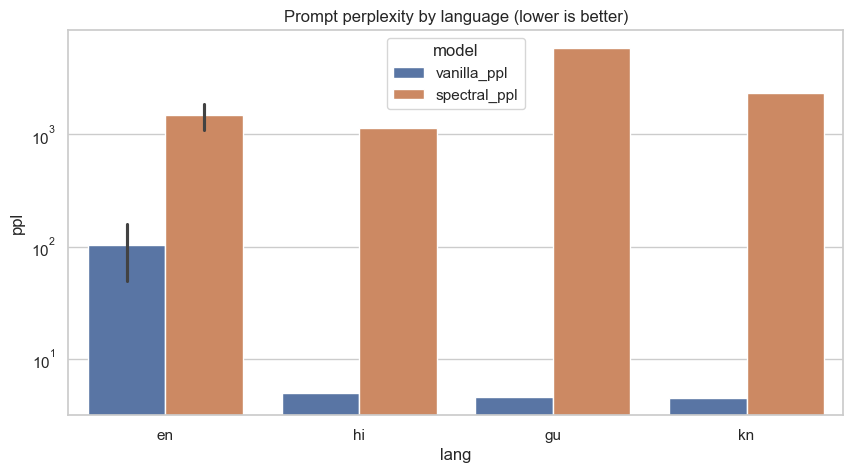

In [7]:
# Simple visualization: bar chart of prompt PPLs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
plt.figure(figsize=(10,5))
vals = df.melt(id_vars=['lang','prompt'], value_vars=['vanilla_ppl','spectral_ppl'],
               var_name='model', value_name='ppl')
sns.barplot(data=vals, x='lang', y='ppl', hue='model')
plt.yscale('log')
plt.title('Prompt perplexity by language (lower is better)')
plt.show()

## Compare multiple spectral checkpoints

Use this section to evaluate several fine-tuned Spectral checkpoints against the same prompts, side-by-side with vanilla GPT-2. Update the paths as needed; missing checkpoints will be skipped.

In [ ]:
def load_spectral_ckpt(model, ckpt_path: str):
    from pathlib import Path
    if ckpt_path and Path(ckpt_path).is_file():
        sd = torch.load(ckpt_path, map_location=device)
        missing, unexpected = model.load_state_dict(sd, strict=False)
        print(f"[spectral_ckpt] loaded {Path(ckpt_path).name} | missing: {len(missing)} | unexpected: {len(unexpected)}")
        return True
    print(f"[spectral_ckpt] not found or empty: {ckpt_path}")
    return False

# List checkpoints to compare (edit as needed)
ckpt_list = [
    "experiments/runs/kd/spectral_kd_2k.pt",
    "experiments/runs/kd/spectral_kd_5k_seq512.pt",  # when available
]

# Evaluate each spectral checkpoint vs vanilla
multi_rows = []
for ck in ckpt_list:
    spec_copy = convert_gpt2lm_to_spectral(GPT2Config.from_pretrained(base_model), from_pretrained=base_model)
    spec_copy = spec_copy.to(device).to(dtype) if dtype != torch.float32 else spec_copy.to(device)
    if not load_spectral_ckpt(spec_copy, ck):
        continue
    for lang, txt in prompts:
        ids = tokenizer([txt], return_tensors='pt', padding=True)['input_ids'].to(device)
        v_loss = prompt_nll(vanilla, ids)
        s_loss = prompt_nll(spec_copy, ids)
        v_ppl = math.exp(v_loss) if v_loss < 20 else float('inf')
        s_ppl = math.exp(s_loss) if s_loss < 20 else float('inf')
        multi_rows.append({
            'ckpt': ck, 'lang': lang, 'prompt': txt,
            'vanilla_ppl': v_ppl, 'spectral_ppl': s_ppl,
            'vanilla_loss': v_loss, 'spectral_loss': s_loss,
        })

multi_df = pd.DataFrame(multi_rows)
multi_df.head()

In [ ]:
# Visualization for multiple checkpoints
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

if not multi_df.empty:
    plt.figure(figsize=(12,6))
    vals = multi_df.melt(id_vars=['ckpt','lang'], value_vars=['vanilla_ppl','spectral_ppl'], var_name='model', value_name='ppl')
    sns.barplot(data=vals, x='lang', y='ppl', hue='model', ci=None)
    plt.yscale('log')
    plt.title('Prompt perplexity by language across Spectral checkpoints (log scale)')
    plt.show()
else:
    print('No checkpoints loaded for multi-compare.')

In [8]:
# Save JSONL outputs (optional)
out_root = Path('experiments/runs/multilang_notebook')
out_root.mkdir(parents=True, exist_ok=True)
outp = out_root / f'results_{time.strftime("%Y%m%d-%H%M%S")}.jsonl'
with open(outp, 'a', encoding='utf-8') as f:
    for _, r in df.iterrows():
        f.write(json.dumps(r.to_dict(), ensure_ascii=False) + '\n')
print('Saved →', outp)

Saved → experiments\runs\multilang_notebook\results_20250917-113559.jsonl
